# Shifted-tilted Tophat at Gaussian first order no shift

Applying first-order shift,tilt to tophat, integrate with HG00

\begin{equation}
	u_{n,m} \rightarrow
     u_{n,m}
        \left[
        1 - \frac{2 a }{w(z)^2} x + i k \alpha x - i \frac{2 k \alpha a}{w(z)^2} x^2 
    \right]
    + 
	a \frac{2 \sqrt{n}}{w(z)} 
	\exp(i \Psi(z))
	u_{n-1,m}
	\left[
        1+ i k \alpha x
    \right]	 \; .
\end{equation}

Scatter these with

\begin{align*}
\sum_{n,m} u_{n,m} \rightarrow 
	\sum_{n,m} 
	\lbrace &
		u_{n+2,m}[ X_+^2(-i\frac{2ka\alpha}{w^2})]
		\\+&
		u_{n+1,m}[ X_+^1(ik\alpha - \frac{2a}{w^2})]
		\\+&
		u_{n,m} [1+X_+^1(ik\alpha \frac{2a\sqrt{n}}{w} e^{i\Psi})- X_0^2 (i\frac{2ka\alpha}{w^2})]
		\\+&
		u_{n-1,m} [\frac{2a\sqrt{n}}{w} e^{i\Psi} + X_-^1(ik\alpha - \frac{2a}{w^2})]
		\\+&
		u_{n-2,m} [ X_-^1(ik\alpha a\frac{2\sqrt{n}}{w}e^{i\Psi}) - X_-^2 (i\frac{2ka\alpha}{w^2})] 	
	\rbrace
\end{align*}

In [1]:
import PauLisa as pl, PL_Plot as plplt,plback as plb, Tophat_integration_AW as th, numpy as np, matplotlib.pyplot as plt, cmath as cm

from numpy import pi as pi
from numpy import angle
from math import e
from numpy import sqrt as sqrt
from scipy.special import erf as erf
import mpmath as mp
import scipy.io

from math import pi, log, exp, sin, cos, atan, e, radians, degrees
from scipy.special import gamma as gamma
from scipy.special import erf as erf
from math import factorial as fact
import cmath
from cmath import sqrt as sqrt
import numpy as np

from time import process_time

inf=np.inf

import pandas as pd
from pprint import pprint


## Tophat coeffients from AW

In [2]:
# mat = scipy.io.loadmat('Top_hat_for_paul.mat')
# coef=mat['coeftop'].ravel()

mat = scipy.io.loadmat('paul_coef_file.mat')
for x in mat:
  print(x)
coef=mat['coeftopUnitInt'].ravel()
print(mat['readmepaul'])

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]/sqrt(area)
    
    

__header__
__version__
__globals__
coeftopUnitInt
coeftopUnitPow
readmepaul
['Two tophat coefficient variables, one for unit power and one for \n unit intensity, should be clear from the name which is which.\nAgain these assume a waist 1/3 of a mm.']


In [3]:


modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

N=28 # mode order
modes_N= pl.create_modes_orderN(listModesM,listModesN,listModesC,NumberModes,N)




## Integration for signals

In [4]:
#loop through and sum over modes overlap where a,b -> n,m
def iterate_modes_overlap(w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y,modes):   

    N = len(modes)
    M = len(modes[0])
    res_arr = [[0 for i in range(10)] for j in range(10)]
    res = 0

    for a in range(N):
        for b in range(M):            
            #ignore zero coeff.
            if (modes[a][b]!=0):
                c_nm = modes[a][b]
                #result is the sum of all overlap coefficients each with a factor of mode coefficient
                res += ( c_nm * th.overlap(a,b,w_1,w_2,zR_1,zR_2,k_1,k_2,d_1,W_2,x_1,x_2,Z,Y) )
                
    return(res)

In [5]:
def signals(v):
    #points determine size of arrays (equivalent to # data points plotted)
    points = v.points
    time_start = process_time()

    time_ave = 0

    #modes_arr = [0]*points
    cl = [0]*points
    cr = [0]*points
    phi_l = [0]*points
    phi_r = [0]*points
    dws = [0]*points
    lps = [0]*points


    #alpha_arr = np.linspace(-500e-6,500e-6,points)

    for p in range (points):
        time_ave_start = process_time()
        #shift x+za
        new_modes = pl.scatter_case2_first_order(v.z,v.params,v.a+v.z*np.sin(v.alpha_arr[p]),v.alpha_arr[p],modes)
        
        #create arrays of overlap coefficients left and right
        cl[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,new_modes) # left overlap (-2e-3,0)

        cr[p] = iterate_modes_overlap(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1R,v.x_2R,v.Z,v.Y,new_modes) # right overlap (0,2e-3)
        time_ave += (process_time()-time_ave_start)

        #create arrays of phases for left and right coeff.
        phi_r[p]=angle(cr[p])
        phi_l[p]=angle(cl[p])
        
        #create arrays of dws &lps for phases in phase arrays
        dws[p] = (phi_r[p]-phi_l[p])
        lps[p] = 0.5*(phi_r[p]+phi_l[p])
    
    #total time for all DWS & LPS points (not including scattering)
    time_elapsed = (process_time() - time_start)
    print(time_elapsed,'s')
    print(time_ave/p,'s')
    
    return(dws,lps)

In [6]:
class Vars:
#modes,alpha with points
    def __init__(self, 
                 lam=1064e-9,
                 z_PD=10e-3,z=10e-3,
                 z_m=0,Z=10e-3,
                 z_LO=0, d_1=10e-3,
                 Y=2e-3,
                 x_1R=10e-6,x_2R=2e-3,
                 x_1L=-2e-3,x_2L=-10e-6,
                 w_1=1e-3, w_2=0.00023067,
                 zR_1=pi*1e-3**2/1064e-9,zR_2=pi*0.00023067**2/1064e-9,
                 k_1=5905249.348852994,k_2=5905249.348852994,
                 params=pl.Params(1064e-9,0.00023067,0),
                 W_2=1,
                 points=21,
                 a=0,alpha_arr=np.linspace(-500e-6,500e-6,21),modes_arr=[0]*21):
        self.lam = lam


        self.z_PD = z_PD #PD location
        self.z = z #prop distance assumed PD

        self.z_m = z_m #meas beam 
        self.Z = Z #distance PD-m

        self.z_LO = z_LO #Local ref. beam
        self.d_1 = d_1 #distance PD-LO


        self.Y = Y #Y int bound

        self.x_1R = x_1R
        self.x_2R = x_2R 

        self.x_1L = x_1L #assumed symmetric with right side
        self.x_2L = x_2L

        self.w_1 = w_1 #waist LO 
        self.w_2 = w_2 #waist MS

        self.zR_1 = zR_1 #rayleigh LO
        self.zR_2 = zR_2


        self.k_1 = k_1 #wavenum LO
        self.k_2 = k_2

        self.params = params #for building tophat coefficients

        self.W_2 = pl.w(z,pl.Params(1064e-9,0.00023067,0)) #tophat beam rad , w(z) or 1e-3?



        #integration and misalignment
        self.points = points

        self.a = a
        self.alpha_arr = alpha_arr

        self.modes_arr = modes_arr

        #build modes from misalignments
        for p in range (points):
            self.modes_arr[p] = pl.scatter_first_order(z,params,a,alpha_arr[p],modes) #array of array of scattered modes#array of array of scattered modes

    def setz(self,z):
        self.z = z #prop distance assumed PD
        self.z_PD = z #PD location
        
        self.Z = z-self.z_m #distance PD-m

        self.d_1 = self.z_PD-self.z_LO #distance PD-LO
    
        self.W_2 = pl.w(z,pl.Params(1064e-9,0.00023067,0))
        
        #scattering also depends on z...
        for p in range (self.points):
            self.modes_arr[p] = [0]*p #clear modes
            self.modes_arr[p] = pl.scatter_first_order(self.z,self.params,self.a,self.alpha_arr[p],modes) #array of array of scattered modes#array of array of scattered modes

        



## Defaults

25.203125 s
1.26015625 s


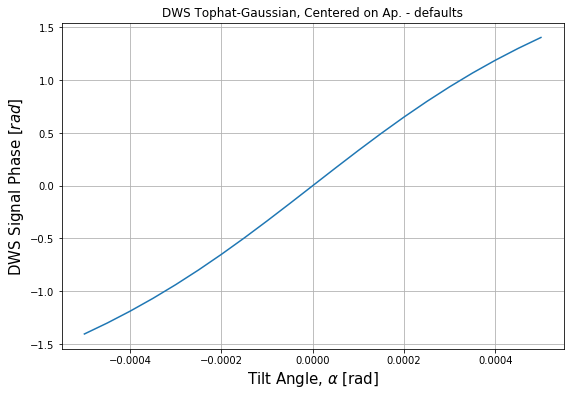

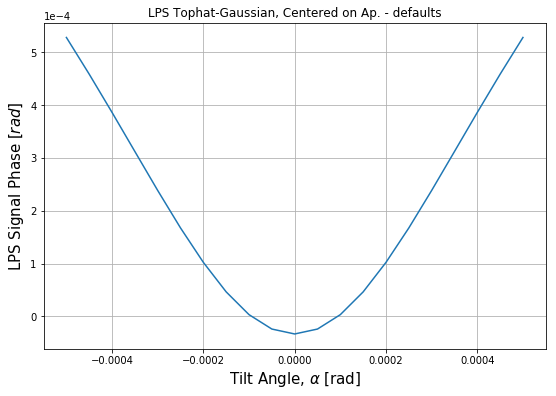

In [7]:
v = Vars()

dws,lps = signals(v)
####################
plt.figure(figsize=(9,6))
plt.plot(v.alpha_arr, dws)

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS Tophat-Gaussian, Centered on Ap. - defaults') 
plt.grid()

#plt.savefig("5-4_HG00_dws.png")
########################
plt.figure(figsize=(9,6))
plt.plot(v.alpha_arr, lps)

plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'LPS Tophat-Gaussian, Centered on Ap. - defaults') 

plt.grid()

#plt.savefig("5-4_HG00_lps.png")

## Distance PD

In [8]:
param_name = 'Distance to PD'
distance_to_pd = [10e-3,5e-3,2e-3,1e-3,0]
dws_arr = [0]*len(distance_to_pd)
lps_arr = [0]*len(distance_to_pd)

ind=0
for i in (distance_to_pd):
    v=Vars()
    v.setz(i)
    dws_arr[ind],lps_arr[ind]=signals(v)
    ind+=1
   # print(v.w_1,v.w_2,v.zR_1,v.zR_2,v.k_1,v.k_2,v.d_1,v.W_2,v.x_1L,v.x_2L,v.Z,v.Y,)

25.953125 s
1.29765625 s
23.125 s
1.15625 s
24.15625 s
1.2078125 s
23.125 s
1.15625 s
22.078125 s
1.10390625 s


0 0.01
1 0.005
2 0.002
3 0.001
4 0


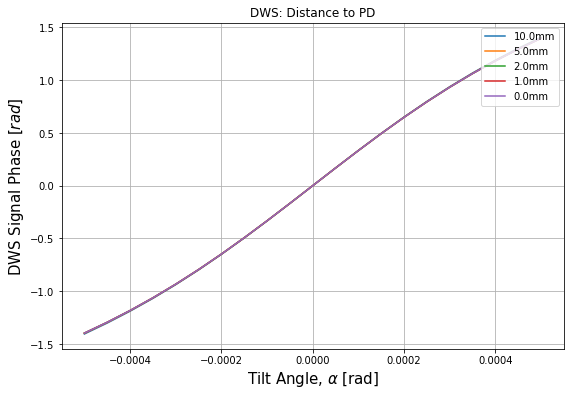

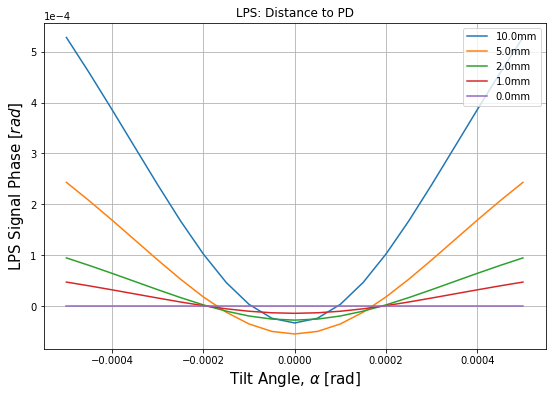

In [9]:
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_arr):
    plt.plot(v.alpha_arr, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

plt.savefig("5-7_TH_dws.png")
########################
plt.figure(figsize=(9,6))

ind=0
for i in (lps_arr):
    plt.plot(v.alpha_arr, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    print(ind,distance_to_pd[ind])
    ind+=1
    
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'LPS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()



#plt.savefig("5-7_TH_lps.png")

0 0.01
1 0.005
2 0.002
3 0.001
4 0


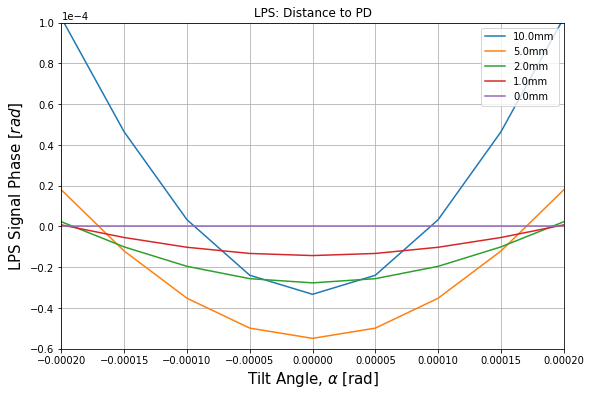

In [10]:
plt.figure(figsize=(9,6))
ind=0
for i in (lps_arr):
    plt.plot(v.alpha_arr, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    print(ind,distance_to_pd[ind])
    ind+=1
    
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'LPS: '+param_name) 
plt.legend(loc='upper right')
plt.xlim([-200e-6,200e-6])
plt.ylim([-.6e-4,1e-4])
plt.grid()



#plt.savefig("5-7_TH_lps.png")

0 0.01
1 0.005
2 0.002
3 0.001
4 0


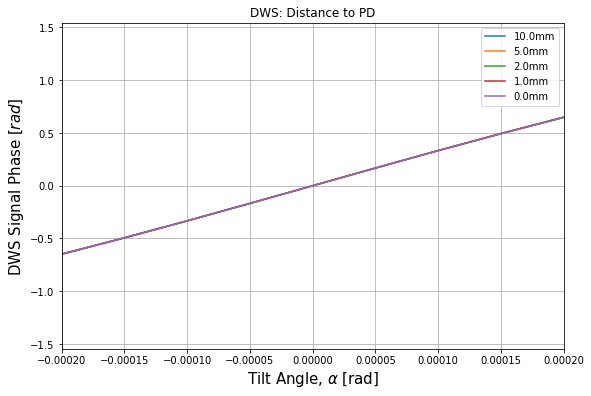

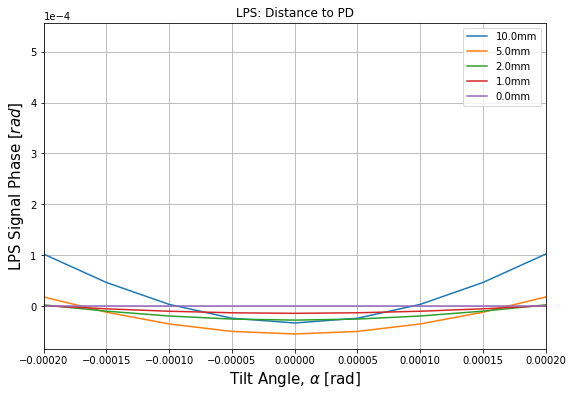

In [11]:
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_arr):
    plt.plot(v.alpha_arr, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.xlim([-200e-6,200e-6])
plt.title(r'DWS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-7_TH_dws.png")
########################
plt.figure(figsize=(9,6))

ind=0
for i in (lps_arr):
    plt.plot(v.alpha_arr, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    print(ind,distance_to_pd[ind])
    ind+=1
    
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.xlim([-200e-6,200e-6])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'LPS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()



#plt.savefig("5-7_TH_lps.png")

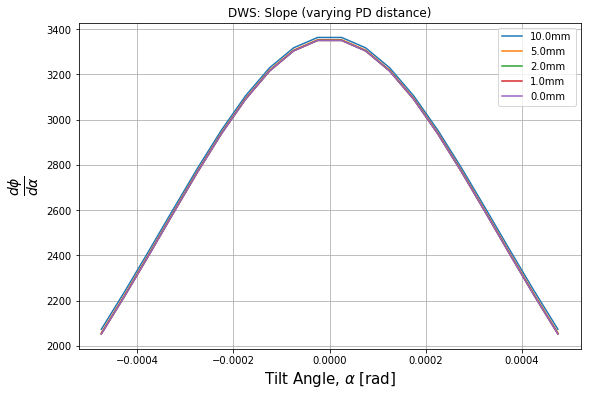

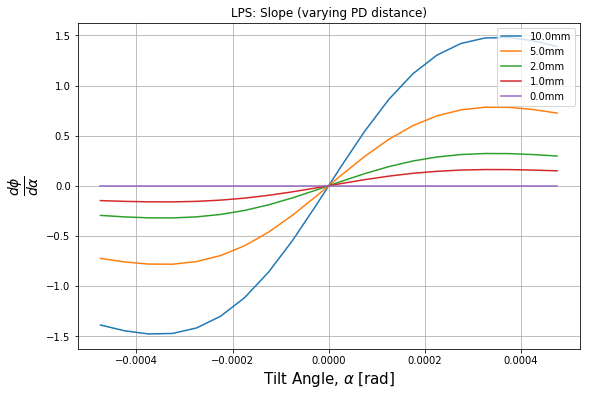

In [12]:
#plot derivs
dws_deriv = [0]*len(dws_arr)
lps_deriv = [0]*len(lps_arr)
ind = 0

for i in dws_arr:
    dws_deriv[ind] = np.diff(i) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    ind+=1
    
  
    
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_deriv):
    plt.plot(alpha2, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d  \phi}{d \alpha}$', fontsize=20) 
#plt.xlim([-200e-6,200e-6])
plt.title(r'DWS: Slope (varying PD distance)') 
plt.legend(loc='upper right')
plt.grid()


ind = 0    
for i in lps_arr:
    lps_deriv[ind] = np.diff(i) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    ind+=1  

    ####################
plt.figure(figsize=(9,6))

ind = 0
for i in (lps_deriv):
    plt.plot(alpha2, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d \phi}{d \alpha}$', fontsize=20) 
#plt.xlim([-200e-6,200e-6])
plt.title(r'LPS: Slope (varying PD distance)') 
plt.legend(loc='upper right')
plt.grid()

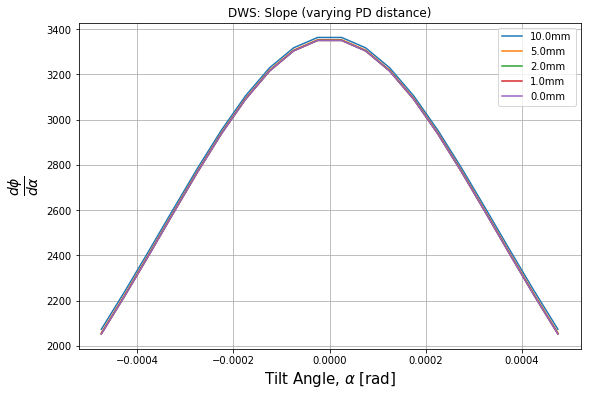

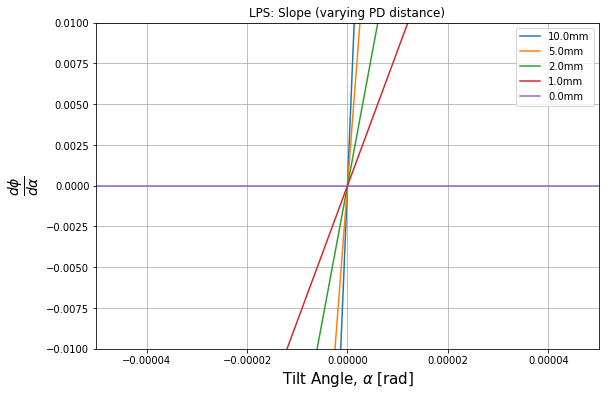

In [13]:
#plot derivs
dws_deriv = [0]*len(dws_arr)
lps_deriv = [0]*len(lps_arr)
ind = 0

for i in dws_arr:
    dws_deriv[ind] = np.diff(i) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    ind+=1
    
  
    
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_deriv):
    plt.plot(alpha2, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d  \phi}{d \alpha}$', fontsize=20) 
#plt.xlim([-200e-6,200e-6])
plt.title(r'DWS: Slope (varying PD distance)') 
plt.legend(loc='upper right')
plt.grid()


ind = 0    
for i in lps_arr:
    lps_deriv[ind] = np.diff(i) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    ind+=1  

    ####################
plt.figure(figsize=(9,6))

ind = 0
for i in (lps_deriv):
    plt.plot(alpha2, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d \phi}{d \alpha}$', fontsize=20) 
plt.xlim([-50e-6,50e-6])
plt.ylim([-1e-2,1e-2])
plt.title(r'LPS: Slope (varying PD distance)') 
plt.legend(loc='upper right')
plt.grid()

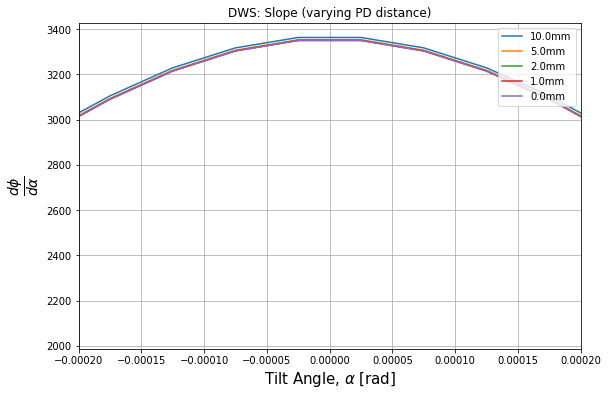

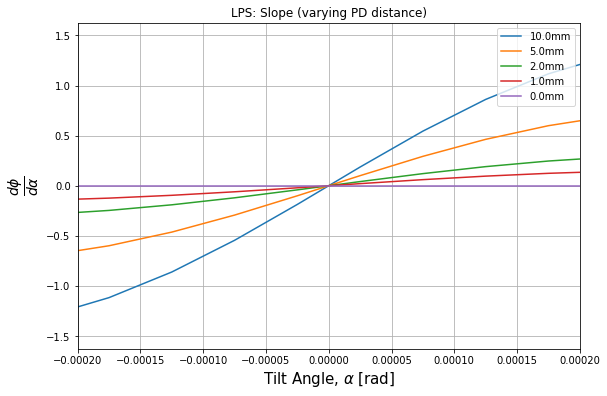

In [14]:
#plot derivs
dws_deriv = [0]*len(dws_arr)
lps_deriv = [0]*len(lps_arr)
ind = 0

for i in dws_arr:
    dws_deriv[ind] = np.diff(i) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    ind+=1
    
  
    
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_deriv):
    plt.plot(alpha2, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d  \phi}{d \alpha}$', fontsize=20) 
plt.xlim([-200e-6,200e-6])
plt.title(r'DWS: Slope (varying PD distance)') 
plt.legend(loc='upper right')
plt.grid()


ind = 0    
for i in lps_arr:
    lps_deriv[ind] = np.diff(i) / np.diff(v.alpha_arr)
    alpha2 = (v.alpha_arr[:-1] + v.alpha_arr[1:]) / 2
    ind+=1  

    ####################
plt.figure(figsize=(9,6))

ind = 0
for i in (lps_deriv):
    plt.plot(alpha2, i,label=str(distance_to_pd[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[rad]',fontsize=15) 
plt.ylabel(r'$ \frac{d \phi}{d \alpha}$', fontsize=20) 
plt.xlim([-200e-6,200e-6])
plt.title(r'LPS: Slope (varying PD distance)') 
plt.legend(loc='upper right')
plt.grid()

## PD Size

In [15]:
param_name = 'PD Size'
par1 = [200e-3,2e-3,1.5e-3,1e-3]
dws_arr1 = [0]*len(par1)
lps_arr1 = [0]*len(par1)
ind=0
for i in (par1):
    v=Vars()
    v.x_2R=i
    v.x_1L=-i
    dws_arr1[ind],lps_arr1[ind]=signals(v)
    ind+=1

22.890625 s
1.14453125 s
25.046875 s
1.25234375 s
25.421875 s
1.27109375 s
23.84375 s
1.1921875 s


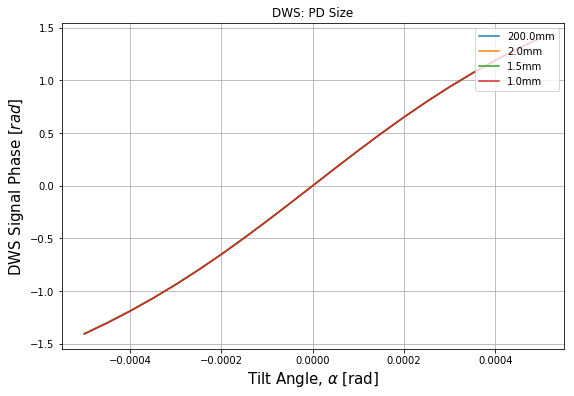

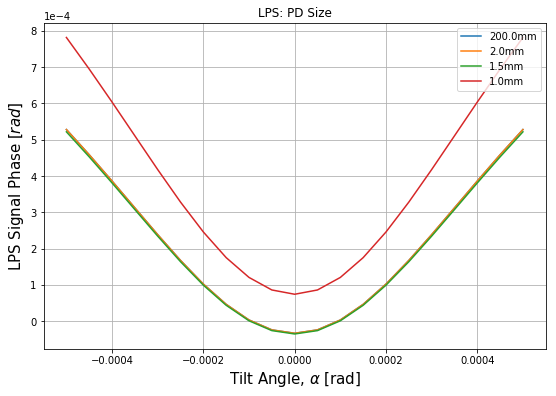

In [16]:
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_arr1):
    plt.plot(v.alpha_arr, i,label=str(par1[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-4_HG00_dws.png")
########################
plt.figure(figsize=(9,6))

ind=0
for i in (lps_arr1):
    plt.plot(v.alpha_arr, i,label=str(par1[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'LPS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-4_HG00_lps.png")

## Gap Size

In [17]:
param_name = 'Gap Size'
par1 = [50e-6,20e-6,0]
dws_arr1 = [0]*len(par1)
lps_arr1 = [0]*len(par1)
ind=0
for i in (par1):
    v=Vars()
    v.x_1R=i
    v.x_2L=-i
    dws_arr1[ind],lps_arr1[ind]=signals(v)
    ind+=1

28.5625 s
1.428125 s
22.9375 s
1.146875 s
25.703125 s
1.28515625 s


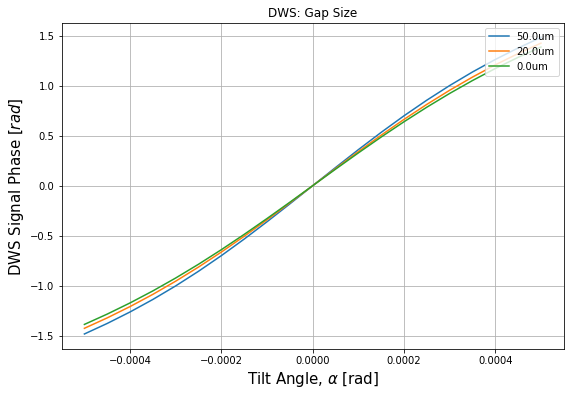

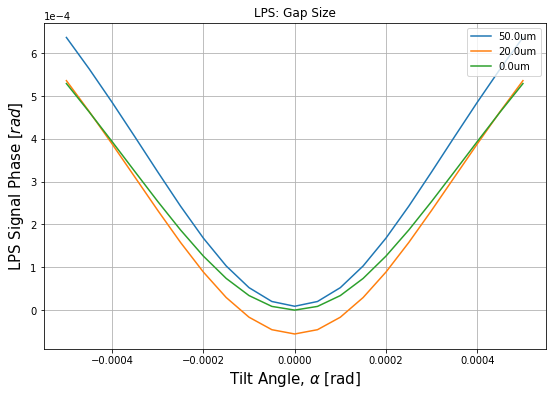

In [18]:
####################
plt.figure(figsize=(9,6))

ind = 0
for i in (dws_arr1):
    plt.plot(v.alpha_arr, i,label=str(par1[ind]*1e6)+'um')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-4_HG00_dws.png")
########################
plt.figure(figsize=(9,6))

ind=0
for i in (lps_arr1):
    plt.plot(v.alpha_arr, i,label=str(par1[ind]*1e6)+'um')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'LPS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-4_HG00_lps.png")

## Ref. beam waist size

In [19]:
param_name = 'Ref. Beam Waist'
par1 = [2e-3,1e-3,0.5e-3]
dws_arr1 = [0]*len(par1)
lps_arr1 = [0]*len(par1)
ind=0
for i in (par1):
    v=Vars()
    v.w_1=i
    dws_arr1[ind],lps_arr1[ind]=signals(v)
    ind+=1

22.5625 s
1.128125 s
24.0 s
1.2 s
25.34375 s
1.2671875 s


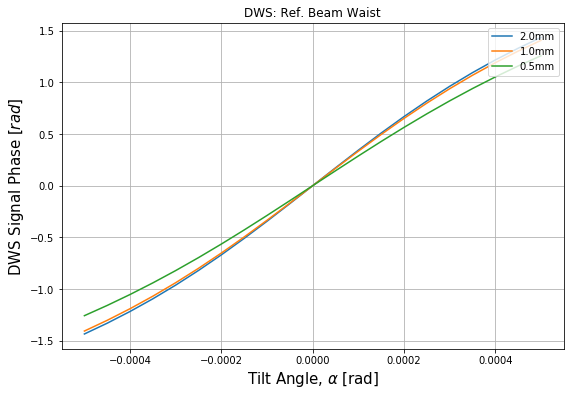

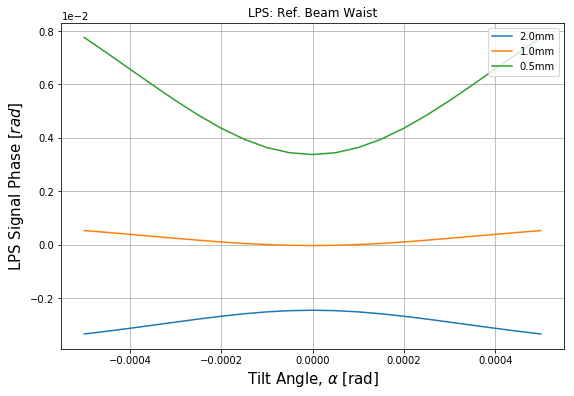

In [20]:
####################
plt.figure(figsize=(9,6))
param_name = 'Ref. Beam Waist'
ind = 0
for i in (dws_arr1):
    plt.plot(v.alpha_arr, i,label=str(par1[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'DWS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.title(r'DWS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-4_HG00_dws.png")
########################
plt.figure(figsize=(9,6))

ind=0
for i in (lps_arr1):
    plt.plot(v.alpha_arr, i,label=str(par1[ind]*1e3)+'mm')
    ind+=1
    
plt.xlabel(r'Tilt Angle, $\alpha\;$[' + 'rad]', fontsize=15) 
plt.ylabel(r'LPS Signal Phase $[' +  'rad]$', fontsize=15) 
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title(r'LPS: '+param_name) 
plt.legend(loc='upper right')
plt.grid()

#plt.savefig("5-4_HG00_lps.png")